In [1]:
import networkx as nx
import numpy as np
import pickle
import random
import os
from pyscipopt import Model, Sepa, Eventhdlr, SCIP_RESULT, SCIP_PARAMSETTING, SCIP_EVENTTYPE

### Feature Extraction (Based on Table 7 of the paper)
The goal is to convert a raw Cutting Plane (a row in the SCIP matrix) into a fixed-size vector (dimension = 13) for the Reinforcement learning policy.
The 13 features are categorized into four groups:
1.  **Cut Coefficients Statistics (4 dims):** Basic statistics (mean, max, min, std) of the constraint coefficients.
2.  **Objective Coefficients Statistics (4 dims):** Statistics of the objective function coefficients $c$ corresponding to the variables involved in the cut.
3.  **Geometric & Structural Features (4 dims):**
     * **Parallelism:** Cosine similarity between the cut's normal vector and the objective function gradient.
     * **Efficacy:** Euclidean distance from the current LP solution to the cut hyperplane.
     * **Support (Sparsity):** Percentage of non-zero coefficients.
     * **Integral Support:** Percentage of integer variables involved in the cut.
4.  **Violation Measure (1 dim):**
     * **Normalized Violation:** How much the current LP solution violates this cut (normalized by the RHS).

In [6]:
def get_features(model, row):
    # Get the variables (cols) and their coefficients (vals) in this cut
    cols = row.getCols()
    vals = row.getVals()
    cut_coeffs = np.array(vals)
    # Gather objective function coefficients for the involved variable
    obj_coeffs = []
    integral_var_count = 0
    for col in cols:
        var = col.getVar() 
        obj_coeffs.append(var.getObj())
        if var.vtype() in ["BINARY", "INTEGER", "IMPLINT"]:
            integral_var_count += 1
    obj_coeffs = np.array(obj_coeffs)
    
    # 1-4: Cut Coefficients Statistics
    f_cut_mean = np.mean(cut_coeffs)
    f_cut_max  = np.max(cut_coeffs)
    f_cut_min  = np.min(cut_coeffs)
    f_cut_std  = np.std(cut_coeffs)
    
    # 5-8: Objective Coefficients Statistics
    if len(obj_coeffs) > 0:
        f_obj_mean = np.mean(obj_coeffs)
        f_obj_max  = np.max(obj_coeffs)
        f_obj_min  = np.min(obj_coeffs)
        f_obj_std  = np.std(obj_coeffs)
    else:
        f_obj_mean, f_obj_max, f_obj_min, f_obj_std = 0.0, 0.0, 0.0, 0.0
    
    # 9: Parallelism
    norm_cut = np.linalg.norm(cut_coeffs)
    norm_obj = np.linalg.norm(obj_coeffs)
    
    if norm_cut > 1e-9 and norm_obj > 1e-9:
        f_parallelism = np.dot(cut_coeffs, obj_coeffs) / (norm_cut * norm_obj)
    else:
        f_parallelism = 0.0
    
    # 10: Efficacy
    f_efficacy = model.getCutEfficacy(row)
    
    # 11: Support
    n_vars_total = model.getNVars()
    f_support = len(cut_coeffs) / (n_vars_total + 1e-5)
    
    # 12: Integral Support
    f_int_support = integral_var_count / (len(cut_coeffs) + 1e-5)
    
    # 13: Normalized Violation
    # max(0, (Activity - RHS) / |RHS|)
    activity = model.getRowActivity(row)
    rhs = row.getRhs()
    denom = abs(rhs) if abs(rhs) > 1e-9 else 1.0
    f_norm_violation = max(0.0, (activity - rhs) / denom)
    
   
    features = np.array([
        f_cut_mean, f_cut_max, f_cut_min, f_cut_std,       # 1-4
        f_obj_mean, f_obj_max, f_obj_min, f_obj_std,       # 5-8
        f_parallelism,                                     # 9
        f_efficacy,                                        # 10
        f_support,                                         # 11
        f_int_support,                                     # 12
        f_norm_violation                                   # 13
    ], dtype=np.float32)
    
    return features

### Reward Monitor

SCIP operates asynchronously:
1.  The **Separator** adds cuts (Action). At this exact moment, the LP has *not* been re-solved yet, so the Dual Bound is unchanged.
2.  SCIP runs the **Simplex Methods** to solve the new LP.
3.  The **Event Handler** (this class) is triggered after the LP is solved. This is the first moment we can observe the effect of the cuts.
 
The Logic
 * **Event:** Listens for `SCIP_EVENTTYPE.LPSOLVED`.
 * **Metric:** Tracks the **Dual Bound** (Linear Relaxation Objective Value).
 * **Reward Calculation:** For a maximization problem (like MIS), the Dual Bound is an Upper Bound. A "good" cut tightens the relaxation, causing the Upper Bound to **decrease**.
      $$Reward = \text{Old Dual Bound} - \text{New Dual Bound}$$

In [7]:
class RewardMonitor(Eventhdlr):    
    def __init__(self):
        # Stores the collected transitions: (state, action, reward)
        self.data = []
        
        # A temporary buffer to hold the (State, Action) pair from the Separator
        # until the LP is solved and the Reward can be calculated.
        # Structure: (state_features, action_indices, old_dual_bound)
        self.pending_transition = None 

    def eventinit(self):
        self.model.catchEvent(SCIP_EVENTTYPE.LPSOLVED, self)

    def eventexit(self):
        self.model.dropEvent(SCIP_EVENTTYPE.LPSOLVED, self)

    def eventexec(self, event):
        # 1. Get the current Dual Bound (LP Objective Value)
        # Note: For Maximization problems (like MIS), the LP relaxation provides an Upper Bound.
        # We want to minimize this Upper Bound (tighten the relaxation).
        current_db = self.model.getLPObjVal()
        
        # 2. Check if there is a pending action waiting to be evaluated
        if self.pending_transition:
            # Unpack the data stored by the Separator
            state, action, old_db = self.pending_transition
            
            # 3. Calculate Reward
            # Logic: Improvement = Old Bound - New Bound
            # If the bound decreased (got tighter), the difference is positive (Reward > 0).
            reward = 0.0
            
            # Filter out cases where the initial bound is infinite (first LP solve)
            if old_db < 1e19: 
                reward = old_db - current_db
            
            # 4. Store the Experience
            # We scale the reward by 10.0 to make the numerical values larger for easier Gradient Descent.
            # Only store the transition if the action has been evaluated.
            self.data.append({
                'state': state,          # The features of candidate cuts
                'action': action,        # The indices of selected cuts
                'reward': reward * 10.0  # The calculated improvement
            })
            
            # 5. Clear the buffer
            self.pending_transition = None
            
        return {}

### Random Data Separator

This class implements the **Separator** component of the SCIP Reinforcement Learning loop. 

1.  **Simulated Cut Generation:**
    * **Challenge:** The `PySCIPOpt` interface does not natively support intercepting the raw "Global Cut Pool" generated by SCIP's internal separators (like Gomory or MIR) before they are added.
    * **Solution:** For this experiment, we only simulate the generation process. We identify fractional variables (e.g., $x = 0.4$) and manually generate simple "Bound Cuts" (e.g., $x \le 0$).

2.  **Random Policy for Exploration:**
    To train a robust RL agent, we need a diverse dataset covering the State-Action space. This separator implements a Random Policy:
    * **Order:** It randomly shuffles the cut list, allowing the model to learn that cut order matters (a key finding of the paper).
    * **Ratio:** It randomly selects a subset size (from 1 to $N$), allowing the model to learn how many cuts to select.

### Workflow
1.  **Generate:** Create candidate cuts based on fractional variables.
2.  **Perceive:** Extract 13-dim features for each candidate ($S_t$).
3.  **Act:** Randomly shuffle and select a subset of cuts ($A_t$).
4.  **Execute:** Add the selected cuts to the SCIP solver.
5.  **Handoff:** Pass the State and Action to the `RewardMonitor` to await the reward signal.

In [8]:
class RandomDataSepa(Sepa):
    def __init__(self, monitor):
        self.monitor = monitor
    # PART A: Candidate Cut Generation (SIMULATION)
    def sepaexeclp(self):
        model = self.model
        # 1. Identify fractional variables (candidates for separation/branching)
        # We look for variables x where 0 < x < 1 (in binary problems)
        vars = model.getVars()
        fractional_vars = [v for v in vars if 0.01 < model.getSolVal(None, v) < 0.99]
        
        candidates = []
        if fractional_vars:
            # Heuristic: Randomly select up to 10 fractional variables to generate cuts for
            n_gen = min(10, len(fractional_vars))
            target_vars = random.sample(fractional_vars, n_gen)
            
            for i, v in enumerate(target_vars):
                # Simulate a cut: 
                # If x is closer to 0, add cut: x <= 0 (Logic: x should probably be 0)
                # If x is closer to 1, add cut: x >= 1 (Logic: x should probably be 1)
                # Note: These resemble "local branching" constraints.
                val = model.getSolVal(None, v)
                cut_name = f"sim_cut_{i}"
                
                if val < 0.5:
                    # Create row: 1.0 * v <= 0.0
                    row = model.createEmptyRowSepa(self, cut_name, lhs=None, rhs=0.0)
                    model.addVarToRow(row, v, 1.0)
                else:
                    # Create row: 1.0 * v >= 1.0
                    row = model.createEmptyRowSepa(self, cut_name, lhs=1.0, rhs=None)
                    model.addVarToRow(row, v, 1.0)
                
                # Validity Check: Only add cuts that are efficacious (actually cut off the current LP solution)
                if model.isCutEfficacious(row):
                    candidates.append(row)
        
        # If no valid cuts could be generated, exit
        if not candidates:
            return {"result": SCIP_RESULT.DIDNOTFIND}
        # PART B: Feature Extraction
        # Convert the physical Row objects into 13-dimensional feature vectors
        state_features = [get_features(model, c) for c in candidates]
        # PART C: Random Policy Execution (Action A_t)
        # Random Policy is used here to explore the state-action space.
        
        # 1. Randomize Order (Addressing "Order Matters" from the paper)
        indices = list(range(len(candidates)))
        random.shuffle(indices)
        
        # 2. Randomize Selection Ratio (Addressing "How many cuts to select")
        # We randomly choose to apply between 1 and all candidates.
        n_select = random.randint(1, len(candidates))
        selected_indices = indices[:n_select]
        
        # PART D: Apply Cuts & Suspend
        # Apply the selected cuts to the SCIP model
        for idx in selected_indices:
            model.addCut(candidates[idx])
            
        # Capture the current objective value (to calculate reward later)
        current_db = model.getLPObjVal()
        
        # Handoff to RewardMonitor: Store (State, Action, Old_Dual_Bound)
        # The monitor will calculate the Reward after SCIP re-solves the LP.
        self.monitor.pending_transition = (state_features, selected_indices, current_db)
        
        return {"result": SCIP_RESULT.SEPARATED}

### Main Program

This is the entry point of the script. It orchestrates the entire data collection process by generating a series of diverse problem instances and letting the **Random Separator** interact with them.

### Workflow per Episode:
1.  **Generate Instance:** Creates a new random graph (Barabasi-Albert model) and formulates the **Maximum Independent Set (MIS)** problem.
2.  **Configure Solver:** * `separating/maxrounds = 5`: Limits the solving time per instance to keep data collection fast.
    * `Presolve = OFF`: Disables SCIP's built-in simplification. This is critical to ensure the problem remains "hard enough" for the agent to learn meaningful cut selection strategies.
3.  **Attach Plugins:** Registers our custom `RandomDataSepa` and `RewardMonitor` into the SCIP environment.
4.  **Solve & Collect:** Runs the optimization. The plugins automatically intercept the process, generate cuts, record features/actions, and calculate rewards.
5.  **Save:** Aggregates all transition data `(s, a, r)` into a pickle file for offline training.

In [23]:
def run_data_collection():
    NUM_EPISODES = 60   # Number of graphs
    NODES = 70          # Graph size
    OUTPUT_FILE = "mis_data_final.pkl"
    
    all_dataset = []
    print(f">>> [Step 1] Starting Data Collection ({NUM_EPISODES} episodes)...")

    for i in range(NUM_EPISODES):
        # 1. Generate Problem
        g = nx.gnp_random_graph(NODES, 0.15,seed=i)
        model = Model(f"MIS_{i}")
        model.hideOutput()
        
        x = {n: model.addVar(vtype="B") for n in g.nodes()}
        for u, v in g.edges():
            model.addCons(x[u] + x[v] <= 1)
        model.setObjective(sum(x.values()), "maximize")
        
        # 2. Setup Environment
        model.setIntParam("separating/maxrounds", 5)
        model.setPresolve(SCIP_PARAMSETTING.OFF)
        
        # 3. Attach Plugins
        monitor = RewardMonitor()
        model.includeEventhdlr(monitor, "RewardMonitor", "")
        sepa = RandomDataSepa(monitor)
        model.includeSepa(sepa, "RandomSepa", "", priority=100000, freq=1)
        
        # 4. Solve
        model.optimize()
        
        # 5. Collect
        if monitor.data:
            all_dataset.extend(monitor.data)
            
        if (i+1) % 10 == 0:
            print(f"  Progress: Episode {i+1}/{NUM_EPISODES}, Collected Samples: {len(all_dataset)}")

    print(f"\n>>> Done! Saving {len(all_dataset)} samples to '{OUTPUT_FILE}'")
    with open(OUTPUT_FILE, "wb") as f:
        pickle.dump(all_dataset, f)

In [24]:
run_data_collection()

>>> [Step 1] Starting Data Collection (60 episodes)...
  Progress: Episode 10/60, Collected Samples: 10
  Progress: Episode 20/60, Collected Samples: 20
  Progress: Episode 30/60, Collected Samples: 30
  Progress: Episode 40/60, Collected Samples: 40
  Progress: Episode 50/60, Collected Samples: 50
  Progress: Episode 60/60, Collected Samples: 60

>>> Done! Saving 60 samples to 'mis_data_final.pkl'


In [3]:

# # Step 1.5: Data Cleaning
# 
# We detected some samples with massive negative rewards (e.g., -1e21). 
# This indicates SCIP returned "Infinity" for the new bound, likely due to numerical resets.
# We must clip these rewards to 0.0 to prevent gradient explosion during training.

# %%
import pickle
import numpy as np

FILE_NAME = "mis_data_final.pkl"

# 1. 加载数据
print(f"cleaning: {FILE_NAME} ...")
with open(FILE_NAME, "rb") as f:
    dataset = pickle.load(f)

cleaned_count = 0
valid_data = []

for sample in dataset:
    r = sample['reward']
    
    # 2. outlier detective
    # reward < -1000
    if r < -1000.0:
        sample['reward'] = 0.0
        cleaned_count += 1
    
    # 3. NaN
    if not np.isnan(np.sum(sample['state'])):
        valid_data.append(sample)

# 3. save
with open(FILE_NAME, "wb") as f:
    pickle.dump(valid_data, f)

print(f"   {cleaned_count} outliers detected")
print(f"   {len(valid_data)} samples remained")

cleaning: mis_data_final.pkl ...
   0 outliers detected
   60 samples remained


Visualization

Total: 60 samples


,Sample_ID,n_Candidates,n_Selected,Reward,Avg_Parallelism,Avg_Efficacy,Max_Efficacy
0,0,10,5,0.0,-1.0,0.5,0.5
1,1,10,10,0.0,-1.0,0.5,0.5
2,2,10,4,0.0,-1.0,0.5,0.5
3,3,10,3,0.0,-1.0,0.5,0.5
4,4,10,3,0.0,-1.0,0.5,0.5



 Top 5 Best Moves):


,Sample_ID,n_Candidates,n_Selected,Reward,Avg_Parallelism,Avg_Efficacy,Max_Efficacy
0,0,10,5,0.0,-1.0,0.5,0.5
1,1,10,10,0.0,-1.0,0.5,0.5
2,2,10,4,0.0,-1.0,0.5,0.5
3,3,10,3,0.0,-1.0,0.5,0.5
4,4,10,3,0.0,-1.0,0.5,0.5



Describe:


,Sample_ID,n_Candidates,n_Selected,Reward,Avg_Parallelism,Avg_Efficacy,Max_Efficacy
count,60.000000,60.0,60.000000,60.0,60.0,60.0,60.0
mean,29.500000,10.0,6.716667,0.0,-1.0,0.5,0.5
std,17.464249,0.0,2.470790,0.0,0.0,0.0,0.0
min,0.000000,10.0,2.000000,0.0,-1.0,0.5,0.5
25%,14.750000,10.0,4.750000,0.0,-1.0,0.5,0.5
50%,29.500000,10.0,6.500000,0.0,-1.0,0.5,0.5
75%,44.250000,10.0,9.000000,0.0,-1.0,0.5,0.5
max,59.000000,10.0,10.000000,0.0,-1.0,0.5,0.5


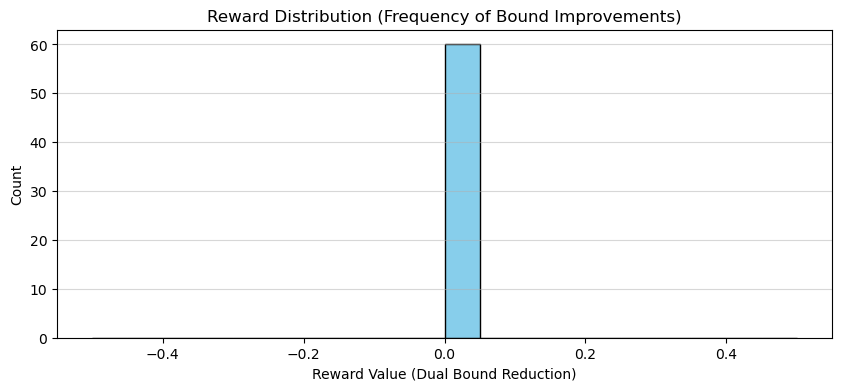

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "mis_data_final.pkl"
with open(file_path, "rb") as f:
    dataset = pickle.load(f)


table_data = []

for i, sample in enumerate(dataset):
    state = np.array(sample['state'])
    action = sample['action']
    reward = sample['reward']

    if len(state) > 0:
        avg_parallelism = np.mean(state[:, 8])
        avg_efficacy = np.mean(state[:, 9])
        avg_violation = np.mean(state[:, 12])
        max_efficacy = np.max(state[:, 9])
    else:
        avg_parallelism, avg_efficacy, avg_violation, max_efficacy = 0, 0, 0, 0

    table_data.append({
        "Sample_ID": i,
        "n_Candidates": len(state),       
        "n_Selected": len(action), 
        "Reward": round(reward, 4),  
        "Avg_Parallelism": round(avg_parallelism, 4), 
        "Avg_Efficacy": round(avg_efficacy, 4),  
        "Max_Efficacy": round(max_efficacy, 4)
    })

df = pd.DataFrame(table_data)

print(f"Total: {len(df)} samples")


display(df.head())
print("\n Top 5 Best Moves):")
display(df.sort_values(by="Reward", ascending=False).head(5))

print("\nDescribe:")
display(df.describe())

# 4.plot
plt.figure(figsize=(10, 4))
plt.hist(df['Reward'], bins=20, color='skyblue', edgecolor='black')
plt.title("Reward Distribution (Frequency of Bound Improvements)")
plt.xlabel("Reward Value (Dual Bound Reduction)")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.5)
plt.show()